In [39]:
# Uncomment only if you want to reprocess the raw data using initial_prep.py
# The script will re-create crashes.gz, comma separated gzipped file in ../data/processed

## %run ../src/preprocessing/initial_prep.py

In [323]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer #, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn import set_config
set_config(display ="diagram")

import matplotlib.pyplot as plt
%matplotlib inline

In [169]:

df=pd.read_csv('../data/processed/crashes.gz', compression='gzip', low_memory=False)

In [170]:
#df.hist(figsize=(20,20));

In [324]:
#sample_df=df.sample(8000, random_state=100)
sample_df=df.copy()

y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, stratify=y)


In [325]:
#ordinal_columns = ['DRIVERS_LICENSE_CLASS']

all_pred = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','ROAD_DEFECT','POSTED_SPEED_LIMIT','VEHICLE_DEFECT',
            'ALIGNMENT', 'LIGHTING_CONDITION', 'WEATHER_CONDITION','SEX','DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION', 'VEHICLE_YEAR', 'VEHICLE_AGE', 'TRAFFIC_CONTROL_DEVICE',
     ]

numeric_columns = ['NUM_PASSENGERS']

nominal_columns = ['DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT' ,  'TRAFFIC_CONTROL_DEVICE']



In [326]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(numeric_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value=0)),
        ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('imputer', SimpleImputer(strategy = 'constant', fill_value='NA')),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


fu = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


X_train_transformed = fu.fit_transform(X_train)
#X_train.info(verbose=True, show_counts=True)


In [174]:
columns=fu.transformer_list[1][1][2].get_feature_names_out()
columns=np.insert(columns, 0, 'Intercept')
transformed_df=pd.DataFrame(X_train_transformed, columns=columns)
#transformed_df

#transformed_df.info(verbose=True, show_counts=True)


In [177]:

baseline_pipe = Pipeline([ ('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
#                          ('standardscale', StandardScaler()),
                          ('model',LogisticRegression(max_iter = 10000, solver = 'newton-cg'))])
baseline_pipe.fit(X_train, y_train)

y_pred_test = baseline_pipe.predict(X_test)
y_pred_train = baseline_pipe.predict(X_train)


C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [178]:
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))
y_hat_train_prob = gs_pipe.decision_function(X_train)
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = gs_pipe.decision_function(X_test)
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")


              precision    recall  f1-score   support

           0       0.82      0.87      0.85    149107
           1       0.73      0.64      0.68     79432

    accuracy                           0.79    228539
   macro avg       0.78      0.76      0.76    228539
weighted avg       0.79      0.79      0.79    228539

------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     49703
           1       0.72      0.64      0.68     26477

    accuracy                           0.79     76180
   macro avg       0.77      0.76      0.76     76180
weighted avg       0.79      0.79      0.79     76180



C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test:0.834766356323195, Train:0.8353366215936566


In [152]:
#pipe_grid = {'model__solver': ['newton-cg','lbfgs']}
pipe_grid = {'model__solver': ['newton-cg']}
gs_pipe = GridSearchCV(estimator=baseline_pipe, param_grid=pipe_grid, cv=10)
gs_pipe

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value=0,
                                                                                                       strategy='constant')),
                                                                                        ('std_scaler',
                                                                                         StandardScaler())])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_na...
                                                                                                                            'TRAFFIC_CONTROL_DEVICE'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value='NA',
                                                                                                       strategy='constant')),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('onehotenc',
                                        OneHotEncoder(drop='first',
                                                      handle_unknown='ignore',
                                                      sparse=False)),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg']})

In [153]:
gs_pipe.fit(X_train, y_train)

C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('fu',
                                        FeatureUnion(transformer_list=[('num_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_names=['NUM_PASSENGERS'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value=0,
                                                                                                       strategy='constant')),
                                                                                        ('std_scaler',
                                                                                         StandardScaler())])),
                                                                       ('cat_pipeline',
                                                                        Pipeline(steps=[('selector',
                                                                                         DataFrameSelector(attribute_na...
                                                                                                                            'TRAFFIC_CONTROL_DEVICE'])),
                                                                                        ('imputer',
                                                                                         SimpleImputer(fill_value='NA',
                                                                                                       strategy='constant')),
                                                                                        ('cat_encoder',
                                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                                       sparse=False))]))])),
                                       ('onehotenc',
                                        OneHotEncoder(drop='first',
                                                      handle_unknown='ignore',
                                                      sparse=False)),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           solver='newton-cg'))]),
             param_grid={'model__solver': ['newton-cg']})

In [155]:
gs_pipe.best_params_

{'model__solver': 'newton-cg'}

In [158]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [166]:
y_hat_train_prob = gs_pipe.decision_function(X_train)
train_roc = roc_auc_score(y_train, y_hat_train_prob)

y_hat_test_prob = gs_pipe.decision_function(X_test)
test_roc = roc_auc_score(y_test, y_hat_test_prob)

print(f"Test:{test_roc}, Train:{train_roc}")

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3907
           1       0.74      0.63      0.68      2093

    accuracy                           0.79      6000
   macro avg       0.78      0.76      0.76      6000
weighted avg       0.79      0.79      0.79      6000

------------
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1302
           1       0.73      0.59      0.66       698

    accuracy                           0.78      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.78      0.78      0.78      2000

Test:0.8327292373646011, Train:0.8459056606473172


C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


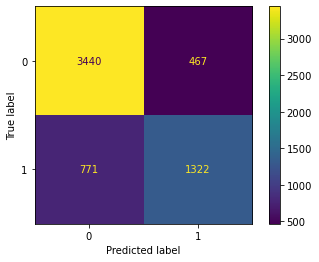

In [102]:

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

In [327]:
bagged_tree_pipe = Pipeline([('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
#                         ('model',DecisionTreeClassifier(splitter='best'))
                          ('model', RandomForestClassifier( n_estimators=150, min_samples_leaf=15)),
#                          ('model', BaggingClassifier(DecisionTreeClassifier(splitter='best', max_depth=5,
#                                                                  min_samples_split=2, min_samples_leaf=8),n_estimators=150))
 
                              ])
bagged_tree_pipe.fit(X_train, y_train)
y_pred_test = baseline_tree_pipe.predict(X_test)
y_pred_train = baseline_tree_pipe.predict(X_train)

print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))



C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.87      0.84    149107
           1       0.71      0.61      0.66     79432

    accuracy                           0.78    228539
   macro avg       0.76      0.74      0.75    228539
weighted avg       0.77      0.78      0.77    228539

------------
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     49703
           1       0.71      0.61      0.66     26477

    accuracy                           0.78     76180
   macro avg       0.76      0.74      0.75     76180
weighted avg       0.77      0.78      0.77     76180



In [287]:
pipe_grid = {'model__max_depth': [ 4, 5, 6,7,8 ], 
            'model__min_samples_leaf':[ 7, 8, 9, 10 ]}

#pipe_grid = {'model__criterion': ['gini', 'entropy']}



gs_pipe = GridSearchCV(estimator=baseline_tree_pipe, 
                       param_grid=pipe_grid, cv=10)

gs_pipe.estimator[2][18]


DecisionTreeClassifier(max_depth=5, min_samples_leaf=8, random_state=349653096)

In [316]:
#gs_pipe.fit(X_train, y_train)

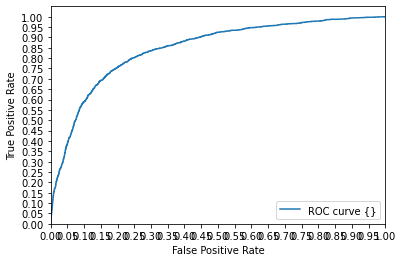

In [189]:
plt.plot(train_fpr, train_tpr,  label='ROC curve {}'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)]);


In [190]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)


C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))


C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These 

C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These 

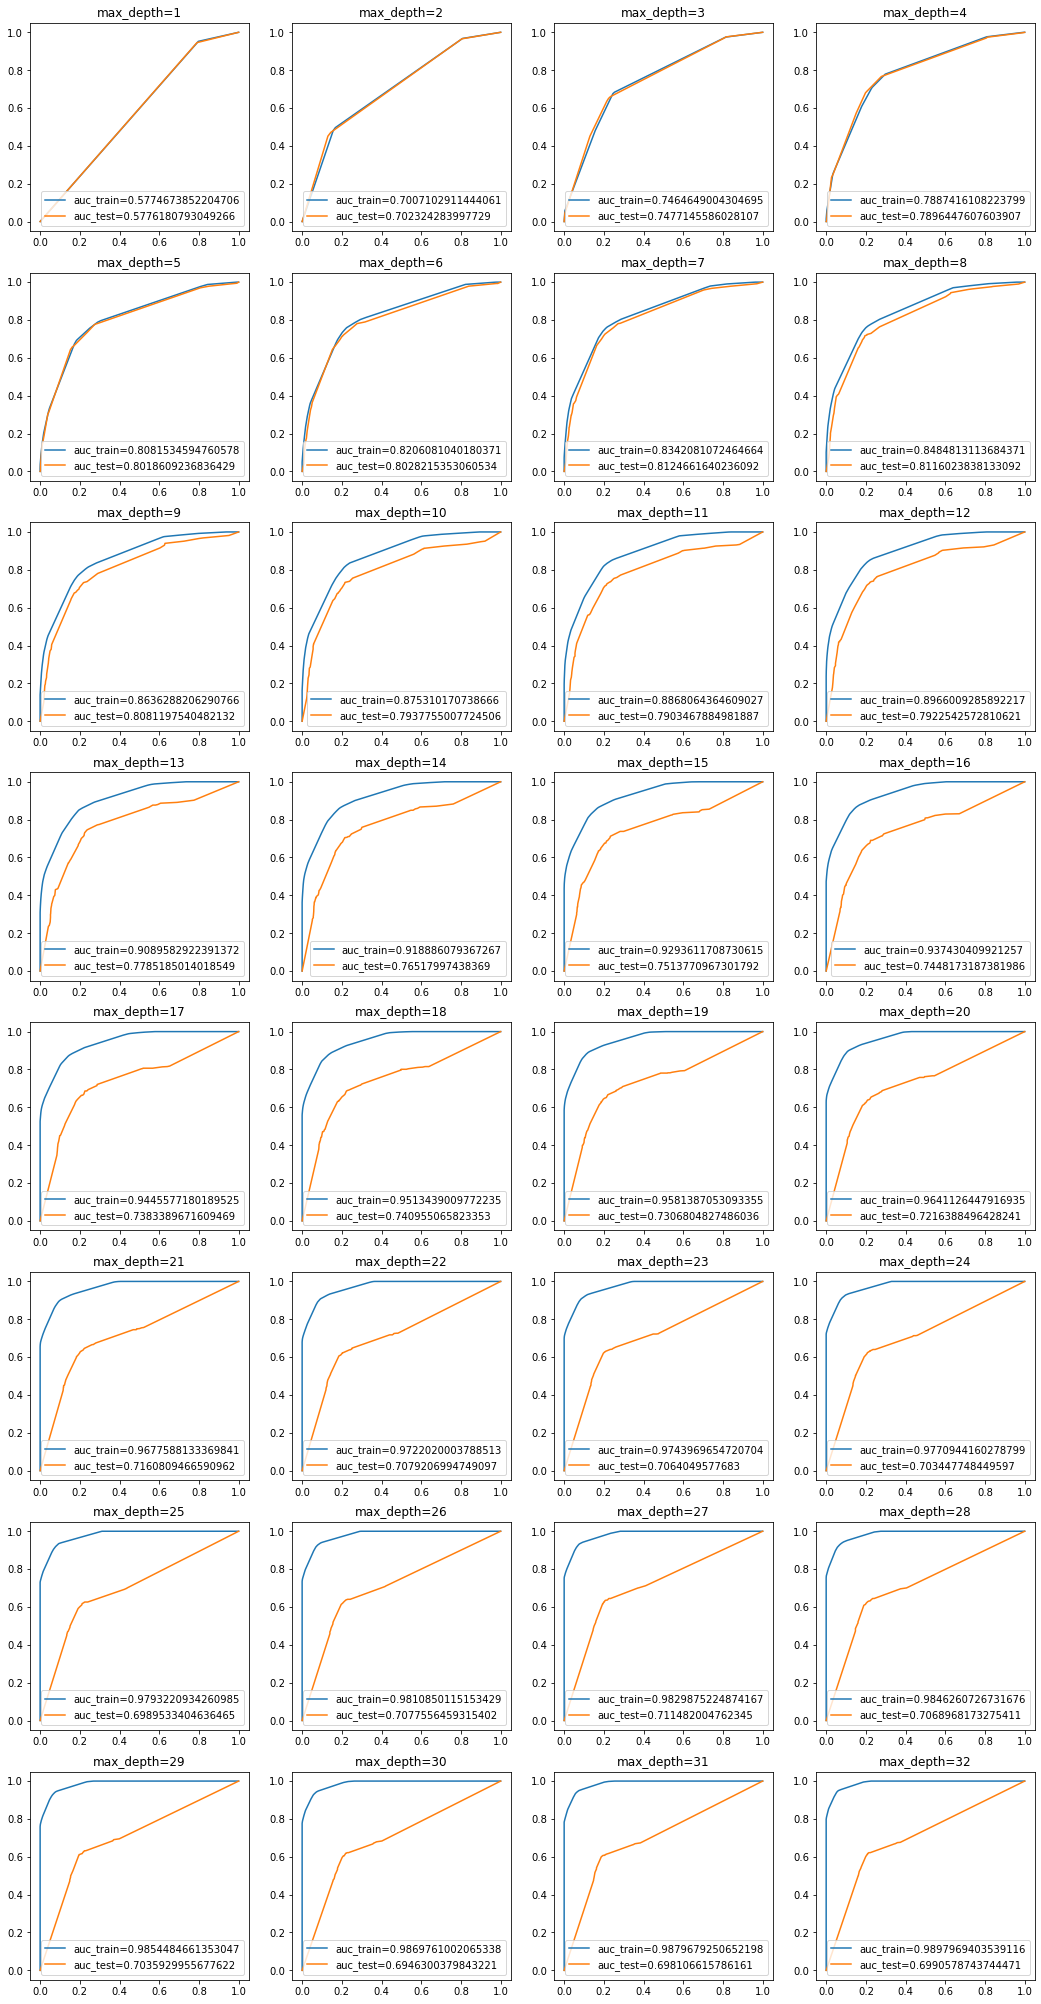

In [98]:
y_hat_train_prob = gs_pipe.decision_function(X_train)
y_score = roc_auc_score(y_train, y_hat_train_prob)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_hat_train_prob)
y_score

max_depth=np.arange(0,32)
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(18,36))
for i in max_depth:
    # Train the classifier using training data
    
    dt = Pipeline([('fu', fu),
                          ('onehotenc', OneHotEncoder(sparse = False, drop = 'first', handle_unknown =  'ignore')),
                          ('model',DecisionTreeClassifier(criterion='entropy', random_state=100,max_depth=i+1))
                              ])
#    dt = DecisionTreeClassifier(criterion='entropy', random_state=100,max_depth=i+1)
    dt.fit(X_train, y_train)
    # Make predictions using test set 
    y_pred = dt.predict(X_test)

    # Check the AUC of predictions
    fpr_test, tpr_test, thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
    roc_auc_test = auc(fpr_test, tpr_test)
    
    fpr_train, tpr_train, thresholds = roc_curve(y_train, dt.predict_proba(X_train)[:,1])
    roc_auc_train = auc(fpr_train, tpr_train)
    
    row = i//4
    col = i%4
    ax = axes[row, col]
    ax.plot(fpr_train, tpr_train, label=f'auc_train={roc_auc_train}')
    ax.plot(fpr_test, tpr_test, label=f'auc_test={roc_auc_test}')
    ax.set_title(f'max_depth={i+1}')
    ax.legend(loc='lower right')